# US President Classifier

The Downloads_President notebook contains the code for downloading the images from google. Obama_Trump_Classification contains a simple example with differentiating Obama vs Trump.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import random

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

assert torch.cuda.is_available() & torch.backends.cudnn.enabled

PATH = "data/presidents/"
PATH_TRAIN = PATH+'train/'

assert os.path.exists(PATH_TRAIN)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
labels = pd.read_csv(PATH+'labels.csv')

In [3]:
n = len(labels.index)
val_idxs = get_cv_idxs(n, seed = 101)
(n, len(val_idxs))

(2707, 541)

In [4]:
labels.head()

,id,label
0,President_Millard_Fillmore46.jpg,President_Millard_Fillmore
1,President_Millard_Fillmore35.jpg,President_Millard_Fillmore
2,President_Millard_Fillmore8.jpg,President_Millard_Fillmore
3,President_Millard_Fillmore0.jpg,President_Millard_Fillmore
4,President_Millard_Fillmore7.jpg,President_Millard_Fillmore


## Initial Model

In [5]:
def get_data(sz, bs = 16): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', val_idxs=val_idxs, 
                                        suffix='', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [6]:
# Let's start with small images
sz = 224
arch = resnet34
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, precompute=True)  # Start with precompute = True

In [7]:
learn.lr_find()

 67%|██████▋   | 91/136 [00:01<00:00, 68.56it/s, loss=4.06]


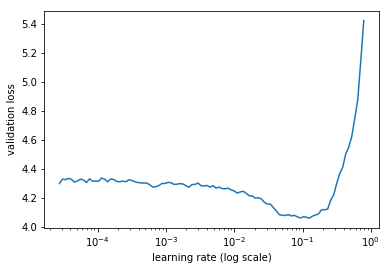

In [8]:
learn.sched.plot()

In [9]:
lr = 2e-2

In [10]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      3.417743   3.039718   0.166359  
    1      2.807061   2.751196   0.225508                   



[array([2.7512]), 0.2255083180674784]

Okay, results are terrible so far.

In [11]:
learn.precompute = False

In [12]:
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.631349   2.618458   0.251386  
    1      2.560602   2.552397   0.292052                   
    2      2.288058   2.553839   0.2939                     
    3      2.396338   2.555808   0.290203                   
    4      2.250755   2.456968   0.336414                   
    5      2.074253   2.438075   0.330869                   
    6      1.940263   2.413751   0.330869                   



[array([2.41375]), 0.33086876171794266]

In [13]:
learn.save('presidents_v1')

At this point we're overfitting as the training loss is lower than the validation loss.

## Increase size

In [14]:
#learn.load('presidents_v1')

In [15]:
sz = 299
learn.set_data(get_data(sz))

In [16]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.220563   2.437344   0.32902   
    1      2.252654   2.410682   0.330869                   
    2      2.093184   2.37019    0.35305                    



[array([2.37019]), 0.3530499077162769]

In [17]:
learn.save('presidents_v2')

## Unfreeze layers

In [18]:
#learn.load('presidents_v2')

In [19]:
learn.unfreeze()

 88%|████████▊ | 119/136 [00:27<00:03,  4.34it/s, loss=9.29]

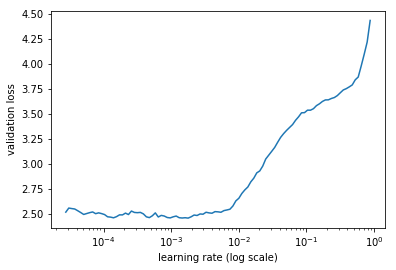

In [20]:
learn.lr_find()
learn.sched.plot()

We're not improving at this point, so I'll only set a really tiny learning rate; let's see what effect it has.

In [21]:
lr = 1e-4/3
lrs = [lr/100, lr/10, lr]

In [22]:
learn.fit(lrs, 1, cycle_len = 4)

epoch      trn_loss   val_loss   accuracy                   
    0      2.510515   2.574042   0.292052  
    1      2.469229   2.519377   0.312384                   
    2      2.452615   2.528243   0.325323                   
    3      2.44019    2.534129   0.308688                   


[array([2.53413]), 0.30868761555434593]

In [23]:
learn.save('presidents_v3')

Yeah, no improvement. Let's go back to the previous version.

## Analyze Results

In [24]:
learn.load('presidents_v2')

In [25]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds)
y = data.val_y

In [26]:
data.classes[:10]

['President_Abraham_Lincoln',
 'President_Andrew_Jackson',
 'President_Andrew_Johnson',
 'President_Barack_Hussein_Obama',
 'President_Benjamin_Harrison',
 'President_Bill_Clinton',
 'President_Calvin_Coolidge',
 'President_Chester_A._Arthur',
 'President_Donald_J._Trump',
 'President_Dwight_D._Eisenhower']

In [27]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def most_by_correct(cat, is_correct = True, num = 4): 
    mask = ((preds == data.val_y)==is_correct) & (data.val_y == cat)
    idxs = np.where(mask, )[0]
    mult = -1 if is_correct else 1
    return idxs[np.argsort(mult*probs[:, cat][idxs])[:num]]

def plot_val_with_title(cat, is_correct = True, title = '', num = 4):
    idxs = most_by_correct(cat, is_correct, num)
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[:, cat][x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Most Incorrect Abraham Lincoln Pics


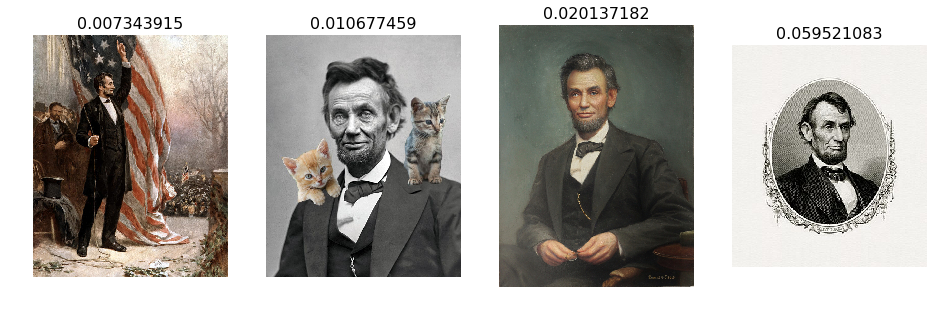

In [28]:
plot_val_with_title(0, False, 'Most Incorrect Abraham Lincoln Pics')

Most Incorrect Donald Trump Pics


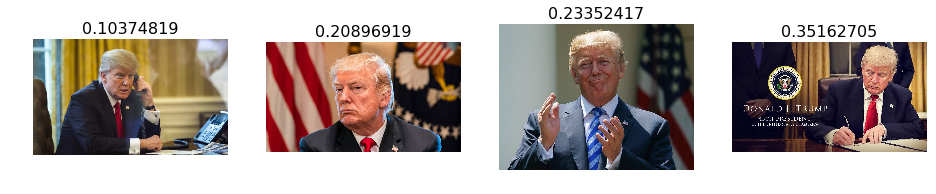

In [29]:
plot_val_with_title(8, False, 'Most Incorrect Donald Trump Pics')